In [95]:
import warnings
#warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# adfuller
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
data = pd.read_csv("daily_means_mauna_loa.csv")
# Year, Month, Day, Date_decimal, CO2
# make index the datetime based on Year, Month, Day
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.index = pd.DatetimeIndex(data['Date'])
data.head()

,Year,Month,Day,Date_decimal,CO2,Date
Date,,,,,,
1974-05-19,1974,5,19,1974.3781,333.46,1974-05-19
1974-05-20,1974,5,20,1974.3808,333.64,1974-05-20
1974-05-21,1974,5,21,1974.3836,333.50,1974-05-21
1974-05-22,1974,5,22,1974.3863,333.21,1974-05-22
1974-05-23,1974,5,23,1974.3890,333.05,1974-05-23


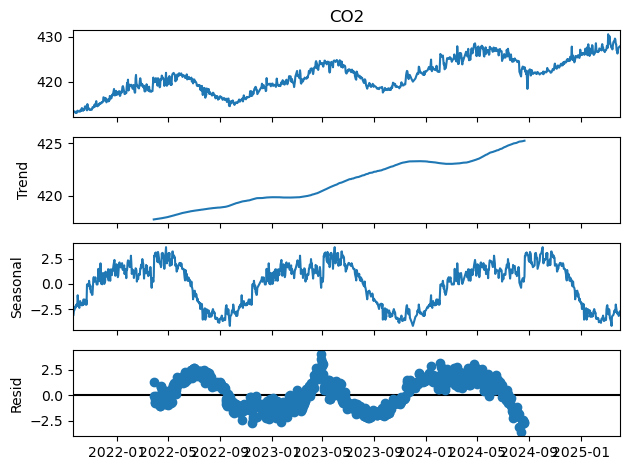

In [132]:
decomposition=seasonal_decompose(data["CO2"][-365*3:],model='additive',period=365)
decomposition.plot()
plt.show()

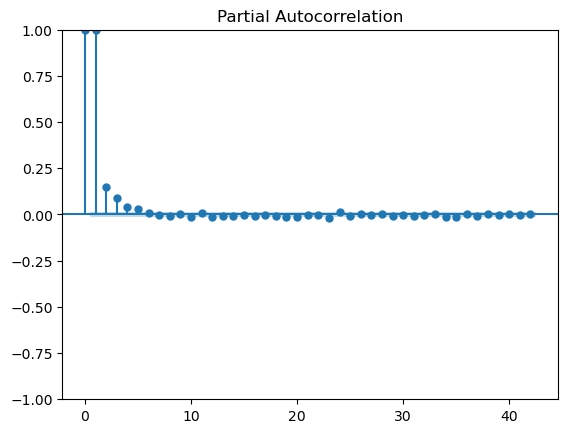

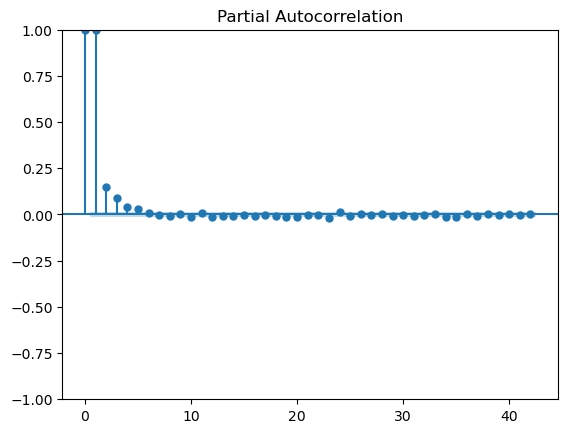

In [98]:
plot_pacf(data["CO2"])

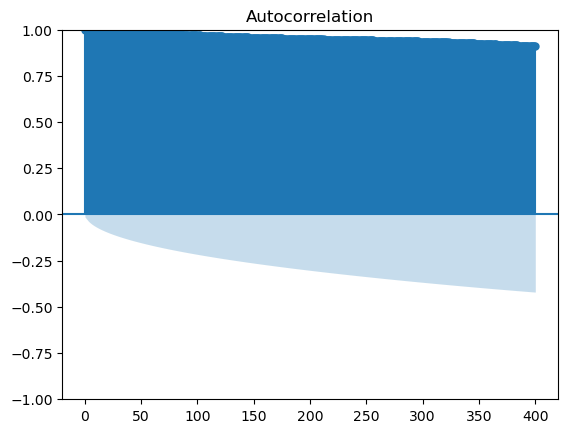

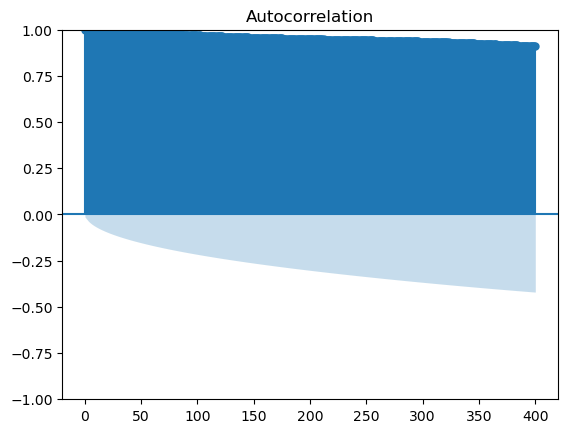

In [99]:
plot_acf(data["CO2"], lags=400)

In [100]:
dftest = adfuller(data['CO2'], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -0.9470612815883948
2. P-Value :  0.7720798603498671
3. Num Of Lags :  38
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 15564
5. Critical Values :
	 1% :  -3.4307702248035485
	 5% :  -2.8617257216784457
	 10% :  -2.5668688550809944


In [ ]:
n = len(data['CO2'])
period = 365

# Define the ranges for the hyperparameters
K_values = range(1, 6)
p_values = range(0, 6) 
q_values = range(0, 6)

best_aic = np.inf
best_params = None
best_model = None


def build_ARMA_fourier_model(p, q, K):
    # Generate Fourier terms for the current K:
    t = np.arange(n)
    sin_terms = [np.sin(2 * np.pi * k * t / period) for k in range(1, K+1)]
    cos_terms = [np.cos(2 * np.pi * k * t / period) for k in range(1, K+1)]
    fourier_terms = np.column_stack(sin_terms + cos_terms)
    
    # Fit ARIMA with order (p, 0, q) and the Fourier terms as exogenous regressors.
    model = sm.tsa.ARIMA(data['CO2'], order=(p, 0, q), exog=fourier_terms)
    results = model.fit()
    
    return results

for K in K_values:
    for p in p_values:
        for q in q_values:
            try:
                model = build_ARMA_fourier_model(K, p, q)
                aic = model.aic
                if aic < best_aic:
                    best_aic = aic
                    best_params = {'K': K, 'p': p, 'q': q}
                    best_model = model
                    print(f"New best model found: p={p}, q={q}, K={K} with AIC={aic:.2f}")
            except Exception as e:
                print(f"Error fitting model with K={K}, p={p}, q={q}: {e}")

print("\nBest model overall:")
print(f"ARIMA order: ({best_params['p']}, 0, {best_params['q']}), Fourier pairs (K): {best_params['K']}, AIC: {best_aic:.2f}")

Error fitting model with K=1, p=0, q=0: need at least one array to concatenate
New best model found: p=0, q=1, K=1 with AIC=28227.42


KeyboardInterrupt: 

In [102]:
model = build_ARMA_fourier_model(1,5,1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                15603
Model:                 ARIMA(1, 0, 5)   Log Likelihood              -12887.851
Date:                Sun, 06 Apr 2025   AIC                          25795.702
Time:                        18:52:57   BIC                          25872.255
Sample:                             0   HQIC                         25821.052
                              - 15603                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        373.7635     31.801     11.753      0.000     311.434     436.093
x1             0.0773      0.159      0.488      0.626      -0.233       0.388
x2            -0.2140      0.156     -1.376      0.169      -0.519       0.091
ar.L1          1.0000   6.62e-05   1.51e+04      0.000       1.000       1.000
ma.L1         -0.3815      0.006    -65.696      0.000      -0.393      -0.370
ma.L2         -0.1485      0.007    -21.973      0.000      -0.162      -0.135
ma.L3         -0.0411      0.007     -5.604      0.000      -0.056      -0.027
ma.L4         -0.0206      0.007     -2.900      0.004      -0.034      -0.007
ma.L5          0.0221      0.007      3.293      0.001       0.009       0.035
sigma2         0.3055      0.002    159.294      0.000       0.302       0.309
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15328.87
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Parameters

Best parameters appear to be K=1, p=1, q=5

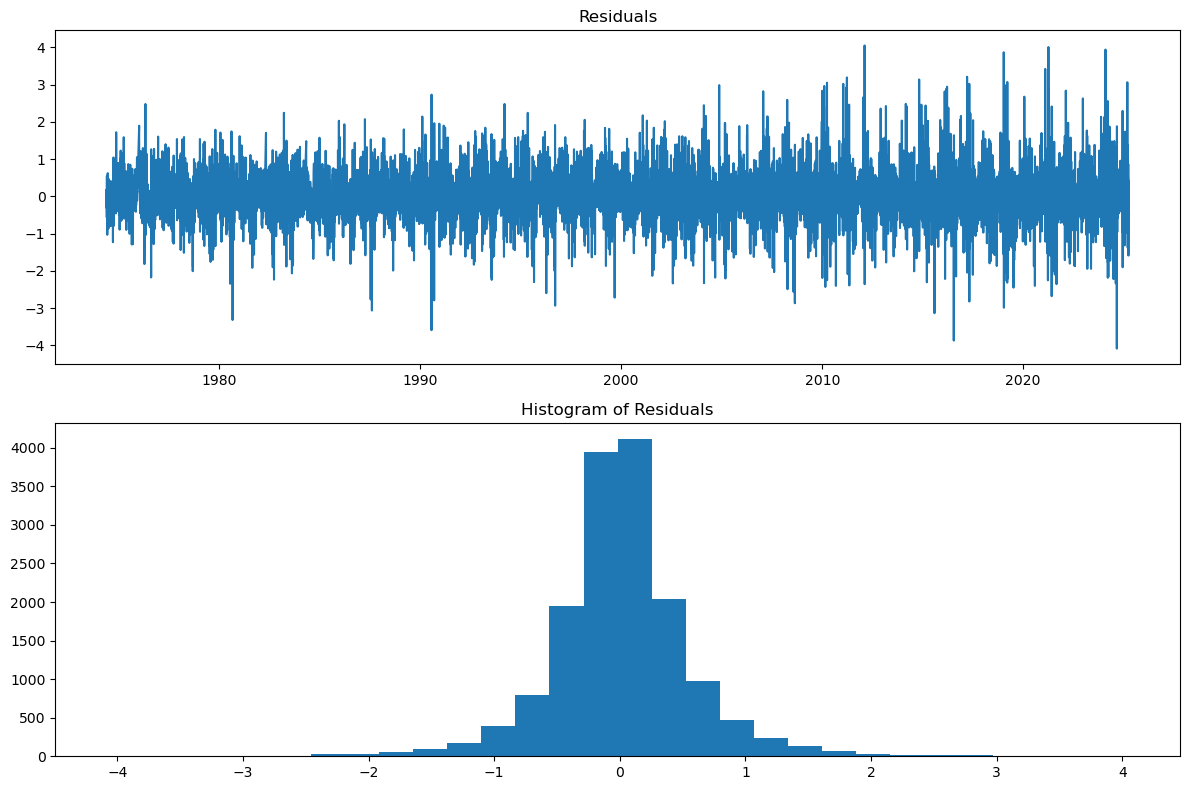

In [103]:
# visualize the residuals
residuals = model.resid[1:]
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(212)
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.show()

Date
2023-01-01    419.478982
2023-01-02    419.318271
2023-01-03    419.309932
2023-01-04    419.497954
2023-01-05    419.225488
                 ...    
2025-03-29    427.457659
2025-03-30    426.906404
2025-03-31    427.182775
2025-04-01    427.340475
2025-04-04    427.513706
Name: predicted_mean, Length: 661, dtype: float64
Date
1974-05-19    333.46
1974-05-20    333.64
1974-05-21    333.50
1974-05-22    333.21
1974-05-23    333.05
               ...  
2025-03-29    426.30
2025-03-30    426.99
2025-03-31    427.42
2025-04-01    427.68
2025-04-04    427.93
Name: CO2, Length: 15603, dtype: float64


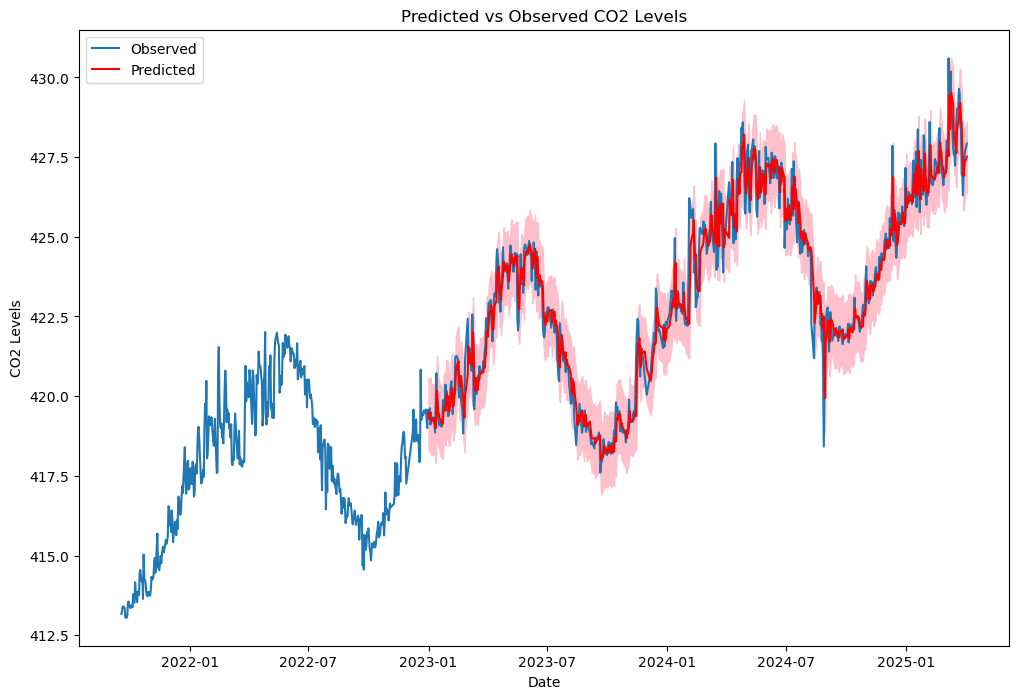

In [105]:
# plot prediction
pred = model.get_prediction(start=pd.to_datetime('2023-01-01'), dynamic=False)
# remove freq from index
prediction_values = pred.predicted_mean
# 
prediction_values.index = prediction_values.index.date
print(pred.predicted_mean)
print(data['CO2'])
pred_conf = pred.conf_int()
plt.figure(figsize=(12, 8))
plt.plot(data['CO2'][-365*3:], label='Observed')
plt.plot(pred.predicted_mean[-365*3:], label='Predicted', color='red')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink')
plt.title('Predicted vs Observed CO2 Levels')
plt.xlabel('Date')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()

# Forecasting

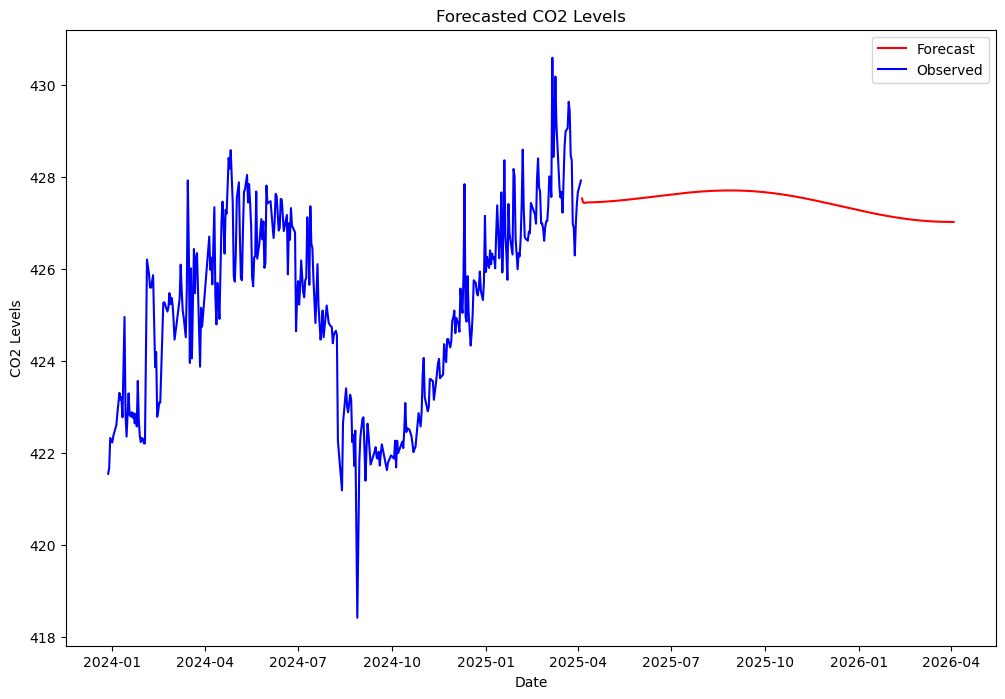

In [ ]:

def forecast_future(model, forecast_steps, K=1):
    try:
        last_date = data.index[-1]
        forecast_index = pd.date_range(start=last_date, periods=forecast_steps+1, freq='D')[1:]
    except Exception:
        forecast_index = np.arange(forecast_steps)
    period=365
    t = np.arange(forecast_steps)
    sin_terms = [np.sin(2 * np.pi * k * t / period) for k in range(1, K+1)]
    cos_terms = [np.cos(2 * np.pi * k * t / period) for k in range(1, K+1)]
    fourier_terms = np.column_stack(sin_terms + cos_terms)

    forecast_obj = model.get_forecast(steps=forecast_steps, exog=fourier_terms)
    forecast_mean = forecast_obj.predicted_mean
    forecast_df = pd.DataFrame({'forecast': forecast_mean})
    forecast_df.index = forecast_index
    return forecast_df

def plot_forecast(forecast_df, lookback_days=365*3):

    plt.figure(figsize=(12, 8))
    plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='red')
    plt.plot(data['CO2'][-lookback_days:], label='Observed', color='blue')
    plt.title('Forecasted CO2 Levels')
    plt.xlabel('Date')
    plt.ylabel('CO2 Levels')
    plt.legend()
    plt.show()

forecast_df = forecast_future(model, forecast_steps=365, K=1)
plot_forecast(forecast_df, lookback_days=365*1)